# Import

In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

# DataBase Connection

In [3]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Data Extraction

In [4]:
query1 = """select id as purchase_id, purchase_date as purchase_date, discount_percent as discount_percent, order_amount as order_amount, vendor_id as purchase_vendor_id from purchase_purchasedata"""

query2 = """select id, quantity as product_quantity, remaining_quantity as remaining_quantity, purchase_price as purchase_price, mrp as mrp, product_size_id as purchase_product_id, purchase_id as purchase_id from purchase_purchaseproductsizedata"""

query3 = """select id as vendor_id, name as vendor_name, created as vendor_created from purchase_vendordata"""

In [5]:
purchase = pd.read_sql(query1, conn)
purchase_product = pd.read_sql(query2, conn)
purchase_vendor = pd.read_sql(query3, conn)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\158222932.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  purchase = pd.read_sql(query1, conn)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\158222932.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  purchase_product = pd.read_sql(query2, conn)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\158222932.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  purchase_vendor = pd.read_sql(query3, conn)


# Deriving Data

In [23]:
final = purchase.merge(purchase_product, left_on = "purchase_id", right_on = "purchase_id", how = "inner")
final = final.merge(purchase_vendor, left_on = "purchase_vendor_id", right_on = "vendor_id", how = "inner")

# Date Filter
# final = final[final["purchase_date"] >= '2022-01-01']
# final = final[final["purchase_date"] <= '2022-12-31']

final['PurchaseDate'] = pd.to_datetime(final['purchase_date'])
final.sort_values(by = ["PurchaseDate"], ascending = True)

,purchase_id,purchase_date,discount_percent,order_amount,purchase_vendor_id,id,product_quantity,remaining_quantity,purchase_price,mrp,purchase_product_id,vendor_id,vendor_name,vendor_created,PurchaseDate
307321,432801,2016-12-19,0.0,7316.0,2.0,340499,3,0,12.7600,16.06,532255,2,Laxmi Medical Agency,2020-05-17 20:36:26.292836+00:00,2016-12-19
307303,432801,2016-12-19,0.0,7316.0,2.0,340481,3,0,34.8800,43.50,514965,2,Laxmi Medical Agency,2020-05-17 20:36:26.292836+00:00,2016-12-19
307304,432801,2016-12-19,0.0,7316.0,2.0,340482,5,0,8.0300,10.00,515042,2,Laxmi Medical Agency,2020-05-17 20:36:26.292836+00:00,2016-12-19
307305,432801,2016-12-19,0.0,7316.0,2.0,340483,3,0,28.4600,35.50,515053,2,Laxmi Medical Agency,2020-05-17 20:36:26.292836+00:00,2016-12-19
307306,432801,2016-12-19,0.0,7316.0,2.0,340484,3,0,37.6900,47.00,515065,2,Laxmi Medical Agency,2020-05-17 20:36:26.292836+00:00,2016-12-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521165,651641,2023-10-03,0.0,119.0,185.0,1463817,2,0,59.5840,128.00,500931,185,MALOO PHARMACEUTICALS,2020-05-17 20:36:28.809067+00:00,2023-10-03
362703,651642,2023-10-03,0.0,193.0,191.0,1463818,2,1,96.3200,100.00,503054,191,GURU SHANTI ENTERPRISES,2020-05-17 20:36:28.888244+00:00,2023-10-03
456623,651645,2023-10-04,0.0,142.0,10.0,1463821,1,0,141.6000,180.00,534868,10,Rajpal Traders,2020-05-17 20:36:26.403585+00:00,2023-10-04
55049,651643,2023-10-04,0.0,96.0,58.0,1463819,1,0,95.7600,100.00,535740,58,S.K. Commercial,2020-05-17 20:36:27.060044+00:00,2023-10-04


In [8]:
vendor_data = final.groupby(["vendor_id"]).agg(
    PurchaseCount = pd.NamedAgg(column = 'purchase_id', aggfunc = 'nunique'),
    PurchaseAmount = pd.NamedAgg(column = 'order_amount', aggfunc = 'sum'),
    NetQuantity = pd.NamedAgg(column = "product_quantity", aggfunc = 'sum'),
    NetRemQuantity = pd.NamedAgg(column = "remaining_quantity", aggfunc = 'sum')).reset_index()
vendor_data["Fill_Ratio"] = 1 - (vendor_data["NetRemQuantity"] / vendor_data["NetQuantity"])
vendor_data

,vendor_id,PurchaseCount,PurchaseAmount,NetQuantity,NetRemQuantity,Fill_Ratio
0,2,4200,141897837.0,121548,191,0.998429
1,3,1495,4264043.0,9904,81,0.991821
2,4,2763,25065358.0,37253,32,0.999141
3,5,796,2299480.0,4254,22,0.994828
4,6,393,435142.0,2559,34,0.986714
...,...,...,...,...,...,...
742,806,1,1692.0,10,0,1.000000
743,807,1,4538.0,20,0,1.000000
744,808,1,338.0,6,3,0.500000
745,809,1,675.0,3,0,1.000000


In [15]:
vendor_data_quartile=vendor_data.sort_values('PurchaseCount', ascending=False)
vendor_data_quartile['Mix']=vendor_data_quartile['PurchaseCount']*100/vendor_data_quartile['PurchaseCount'].sum()
vendor_data_quartile['CumuSum']=vendor_data_quartile['Mix'].cumsum()
vendor_data_quartile['PurchaseCountTag']=0
vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"PurchaseCountTag"]='Top Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>25) & (vendor_data_quartile['CumuSum']<=50),"PurchaseCountTag"]='Above Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>50) & (vendor_data_quartile['CumuSum']<=75),"PurchaseCountTag"]='Below Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>75) & (vendor_data_quartile['CumuSum']<=101),"PurchaseCountTag"]='Lagging Vendors'

vendor_data_quartile=vendor_data_quartile.sort_values('PurchaseAmount', ascending=False)
vendor_data_quartile['Mix']=vendor_data_quartile['PurchaseAmount']*100/vendor_data_quartile['PurchaseAmount'].sum()
vendor_data_quartile['CumuSum']=vendor_data_quartile['Mix'].cumsum()
vendor_data_quartile['PurchaseAmountTag']=0
vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"PurchaseAmountTag"]='Top Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>25) & (vendor_data_quartile['CumuSum']<=50),"PurchaseAmountTag"]='Above Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>50) & (vendor_data_quartile['CumuSum']<=75),"PurchaseAmountTag"]='Below Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>75) & (vendor_data_quartile['CumuSum']<=101),"PurchaseAmountTag"]='Lagging Vendors'

vendor_data_quartile=vendor_data_quartile.sort_values('Fill_Ratio', ascending=False)
vendor_data_quartile['Mix']=vendor_data_quartile['Fill_Ratio']*100/vendor_data_quartile['Fill_Ratio'].sum()
vendor_data_quartile['CumuSum']=vendor_data_quartile['Mix'].cumsum()
vendor_data_quartile['Fill_RatioTag']=0
vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"Fill_RatioTag"]='Top Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>25) & (vendor_data_quartile['CumuSum']<=50),"Fill_RatioTag"]='Above Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>50) & (vendor_data_quartile['CumuSum']<=75),"Fill_RatioTag"]='Below Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>75) & (vendor_data_quartile['CumuSum']<=101),"Fill_RatioTag"]='Lagging Vendors'

vendor_data_quartile=vendor_data_quartile.sort_values('NetQuantity', ascending=False)
vendor_data_quartile['Mix']=vendor_data_quartile['NetQuantity']*100/vendor_data_quartile['NetQuantity'].sum()
vendor_data_quartile['CumuSum']=vendor_data_quartile['Mix'].cumsum()
vendor_data_quartile['NetQuantityTag']=0
vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"NetQuantityTag"]='Top Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>25) & (vendor_data_quartile['CumuSum']<=50),"NetQuantityTag"]='Above Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>50) & (vendor_data_quartile['CumuSum']<=75),"NetQuantityTag"]='Below Average Vendors'
vendor_data_quartile.loc[(vendor_data_quartile['CumuSum']>75) & (vendor_data_quartile['CumuSum']<=101),"NetQuantityTag"]='Lagging Vendors'

vendor_data_quartile = vendor_data_quartile[["vendor_id", "PurchaseCount", "PurchaseAmount", "NetQuantity", "Fill_Ratio", "PurchaseCountTag", "PurchaseAmountTag", "NetQuantityTag", "Fill_RatioTag"]]
vendor_data_quartile

C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\1874622227.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Top Vendors' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"PurchaseCountTag"]='Top Vendors'
C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\1874622227.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Top Vendors' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vendor_data_quartile.loc[vendor_data_quartile['CumuSum']<=25,"PurchaseAmountTag"]='Top Vendors'
C:\Users\CEPL\AppData\Local\Temp\ipykernel_828\1874622227.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Top Vendors' has dtype incompatible with int64, please ex

,vendor_id,PurchaseCount,PurchaseAmount,NetQuantity,Fill_Ratio,PurchaseCountTag,PurchaseAmountTag,NetQuantityTag,Fill_RatioTag
174,185,10512,1.281528e+09,655908,0.997306,Top Vendors,Top Vendors,Top Vendors,Below Average Vendors
180,191,6034,3.514415e+08,339559,0.996145,Top Vendors,Below Average Vendors,Top Vendors,Lagging Vendors
151,162,5688,4.056515e+08,336438,0.995393,Top Vendors,Above Average Vendors,Above Average Vendors,Lagging Vendors
52,58,5546,3.798797e+08,312568,0.996401,Top Vendors,Above Average Vendors,Above Average Vendors,Below Average Vendors
467,511,7045,3.880030e+08,245196,1.000000,Top Vendors,Above Average Vendors,Above Average Vendors,Below Average Vendors
...,...,...,...,...,...,...,...,...,...
288,303,1,1.100000e+02,1,1.000000,Lagging Vendors,Lagging Vendors,Lagging Vendors,Above Average Vendors
592,646,1,9.900000e+01,1,1.000000,Lagging Vendors,Lagging Vendors,Lagging Vendors,Above Average Vendors
58,65,1,7.900000e+01,1,1.000000,Lagging Vendors,Lagging Vendors,Lagging Vendors,Above Average Vendors
130,141,1,7.500000e+01,1,1.000000,Lagging Vendors,Lagging Vendors,Lagging Vendors,Above Average Vendors


In [21]:
metrics = ["PurchaseCount", "PurchaseAmount", "Fill_Ratio", "NetQuantity"]
parameter = "PurchaseCount"
tagname = f'{parameter}Tag'
table = vendor_data_quartile[["vendor_id", "PurchaseCount", "PurchaseAmount", "NetQuantity", "Fill_Ratio", tagname]]
view = table.groupby(tagname).agg(
    VendorCount=pd.NamedAgg(column='vendor_id', aggfunc='nunique'),
    AveragePurchaseCount=pd.NamedAgg(column='PurchaseCount', aggfunc='mean'),
    AveragePurchaseAmount=pd.NamedAgg(column='PurchaseAmount', aggfunc='mean'),
    AverageNetQuantity=pd.NamedAgg(column='NetQuantity', aggfunc='mean'),
    AverageFill_Ratio=pd.NamedAgg(column='Fill_Ratio', aggfunc='mean')).reset_index()
view = view.reindex([3, 0, 1, 2]).reset_index().iloc[:, 1:]
view

,PurchaseCountTag,VendorCount,AveragePurchaseCount,AveragePurchaseAmount,AverageNetQuantity,AverageFill_Ratio
0,Top Vendors,8,6449.375000,3.936061e+08,281372.500000,0.996755
1,Above Average Vendors,14,3916.500000,8.061597e+07,93755.071429,0.996548
2,Below Average Vendors,30,1809.533333,2.176640e+07,35551.366667,0.993766
3,Lagging Vendors,695,78.084892,8.157764e+05,981.964029,0.967576


In [27]:
typemain = "Top Vendors"
view = vendor_data_quartile[vendor_data_quartile[tagname] == typemain]
view = view.sort_values(parameter, ascending = False)
view = view[["vendor_id", "PurchaseCount", "PurchaseAmount", "NetQuantity", "Fill_Ratio"]]
view

,vendor_id,PurchaseCount,PurchaseAmount,NetQuantity,Fill_Ratio
174,185,10512,1.281528e+09,655908,0.997306
467,511,7045,3.880030e+08,245196,1.000000
180,191,6034,3.514415e+08,339559,0.996145
306,321,5804,1.448300e+08,114958,0.996407
151,162,5688,4.056515e+08,336438,0.995393
52,58,5546,3.798797e+08,312568,0.996401
51,57,5537,7.642448e+07,99420,0.997737
65,74,5429,1.210902e+08,146933,0.994651


In [29]:
print(view)

     vendor_id  PurchaseCount  PurchaseAmount  NetQuantity  Fill_Ratio
174        185          10512    1.281528e+09       655908    0.997306
467        511           7045    3.880030e+08       245196    1.000000
180        191           6034    3.514415e+08       339559    0.996145
306        321           5804    1.448300e+08       114958    0.996407
151        162           5688    4.056515e+08       336438    0.995393
52          58           5546    3.798797e+08       312568    0.996401
51          57           5537    7.642448e+07        99420    0.997737
65          74           5429    1.210902e+08       146933    0.994651


In [8]:
Fill_RatioTag_Analysis = vendor_data_quartile.groupby("Fill_RatioTag").agg(
    Average_Fill_Ratio = pd.NamedAgg(column = 'Fill_Ratio', aggfunc = 'mean'),
    VendorCount = pd.NamedAgg(column = 'Fill_RatioTag', aggfunc = 'count')).reset_index()

NetQuantityTag_Analysis = vendor_data_quartile.groupby("NetQuantityTag").agg(
    Average_NetQuantity = pd.NamedAgg(column = 'NetQuantity', aggfunc = 'mean'),
    VendorCount = pd.NamedAgg(column = 'NetQuantityTag', aggfunc = 'count')).reset_index()

In [9]:
# Fill_RatioTag_Analysis
NetQuantityTag_Analysis

,NetQuantityTag,Average_NetQuantity,VendorCount
0,FastMovingVendors,220271.285714,7
1,NonMovingVendors,1864.301105,724
2,SlowMovingVendors,101816.928571,14
3,TopVendors,497733.500000,2


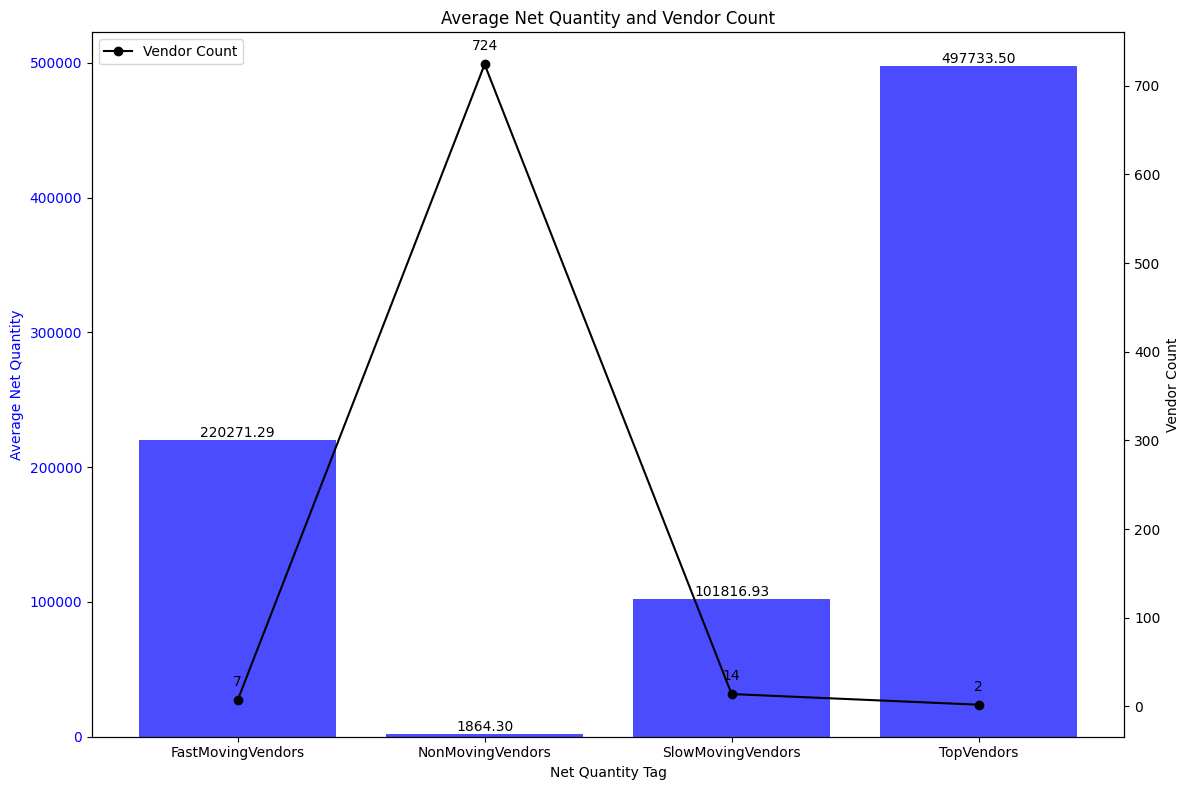

In [10]:
fig, ax1 = plt.subplots(figsize = (12, 8))
bar = ax1.bar(NetQuantityTag_Analysis['NetQuantityTag'], NetQuantityTag_Analysis['Average_NetQuantity'], color='blue', alpha=0.7, label='Average Net Quantity')
ax1.set_xlabel('Net Quantity Tag')
ax1.set_ylabel('Average Net Quantity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a line plot for VendorCount on the right y-axis
ax2 = ax1.twinx()
ax2.plot(NetQuantityTag_Analysis['NetQuantityTag'], NetQuantityTag_Analysis['VendorCount'], color='black', marker='o', label='Vendor Count')
ax2.set_ylabel('Vendor Count', color='black')
ax2.tick_params(axis='y', labelcolor='black')

for bar, avg_net_quantity in zip(bar, NetQuantityTag_Analysis['Average_NetQuantity']):
    ax1.annotate(f'{avg_net_quantity:.2f}', (bar.get_x() + bar.get_width() / 2, avg_net_quantity), ha='center', va='bottom')
for x, y in zip(NetQuantityTag_Analysis['NetQuantityTag'], NetQuantityTag_Analysis['VendorCount']):
    ax2.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('Average Net Quantity and Vendor Count')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
vendor_data_quartile[vendor_data_quartile["NetQuantityTag"] == "TopVendors"]["vendor_name"]

174      MALOO PHARMACEUTICALS
180    GURU SHANTI ENTERPRISES
Name: vendor_name, dtype: object

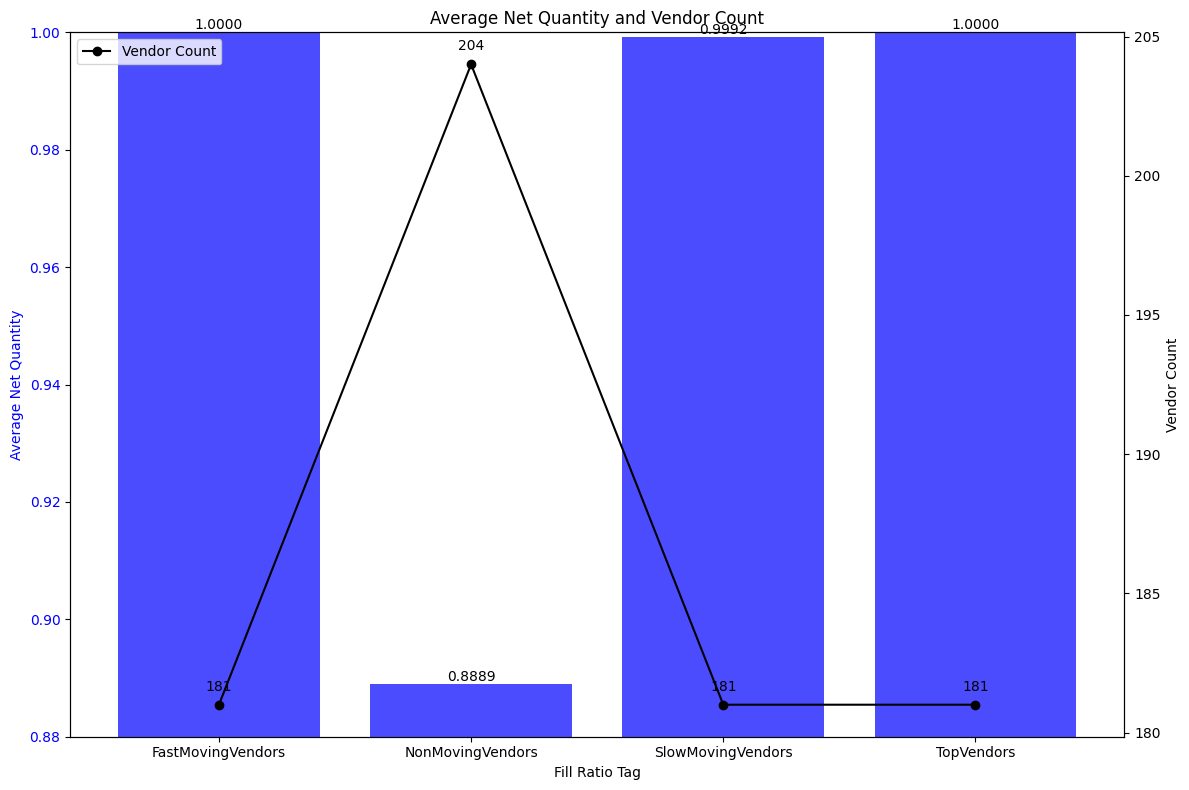

In [12]:
fig, ax1 = plt.subplots(figsize = (12, 8))
bar = ax1.bar(Fill_RatioTag_Analysis['Fill_RatioTag'], Fill_RatioTag_Analysis['Average_Fill_Ratio'], color='blue', alpha=0.7, label='Average Net Quantity')
ax1.set_xlabel('Fill Ratio Tag')
ax1.set_ylabel('Average Net Quantity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a line plot for VendorCount on the right y-axis
ax2 = ax1.twinx()
ax2.plot(Fill_RatioTag_Analysis['Fill_RatioTag'], Fill_RatioTag_Analysis['VendorCount'], color='black', marker='o', label='Vendor Count')
ax2.set_ylabel('Vendor Count', color='black')
ax2.tick_params(axis='y', labelcolor='black')

for bar, avg_net_quantity in zip(bar, Fill_RatioTag_Analysis['Average_Fill_Ratio']):
    ax1.annotate(f'{avg_net_quantity:.4f}', (bar.get_x() + bar.get_width() / 2, avg_net_quantity), ha='center', va='bottom')
for x, y in zip(Fill_RatioTag_Analysis['Fill_RatioTag'], Fill_RatioTag_Analysis['VendorCount']):
    ax2.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title('Average Net Quantity and Vendor Count')
ax1.set_ylim(0.88, 1.0)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
vendor_data_quartile[vendor_data_quartile["Fill_RatioTag"] == "TopVendors"]["vendor_name"]

467    Bilaspur Stock Transfer Vendor
469        Durg Stock Transfer Vendor
446     ALTHEA PHARMA PRIVATE LIMITED
447              MAHARAJA ENTERPRISES
445                       ABOUTTHEFIT
                    ...              
285                        A K AGENCY
669                  B.R DRUG AGENCY 
308                     Mahesh PHARMA
478                          LENSKART
295     SIDDHARTH PLASTIC CORPORATION
Name: vendor_name, Length: 181, dtype: object

# Alert

In [14]:
final['week_start'] = final['PurchaseDate'].dt.to_period('W').dt.start_time
vendor_week_data = final.groupby(["week_start"]).agg(
    VendorCount = pd.NamedAgg(column = "vendor_id", aggfunc = 'nunique'),
    NetQuantity = pd.NamedAgg(column = "product_quantity", aggfunc = 'sum'),
    NetRemQuantity = pd.NamedAgg(column = "remaining_quantity", aggfunc = 'sum')).reset_index()
vendor_week_data["Fill_Ratio"] = 1 - (vendor_week_data["NetRemQuantity"] / vendor_week_data["NetQuantity"])

In [15]:
vendor_week_data.iloc[-10:-5]

,week_start,VendorCount,NetQuantity,NetRemQuantity,Fill_Ratio
343,2023-07-17,176,16658,336,0.979830
344,2023-07-24,186,15430,565,0.963383
345,2023-07-31,180,18430,621,0.966305
346,2023-08-07,182,16713,786,0.952971
347,2023-08-14,180,13246,998,0.924657


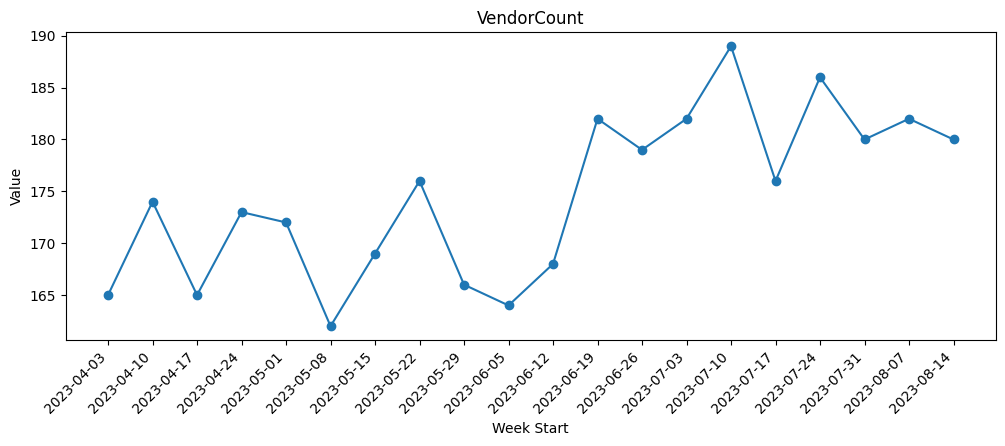

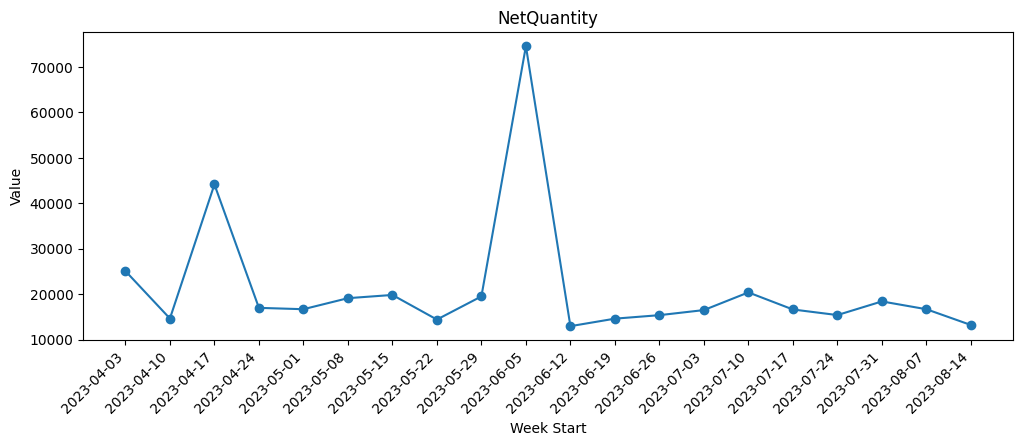

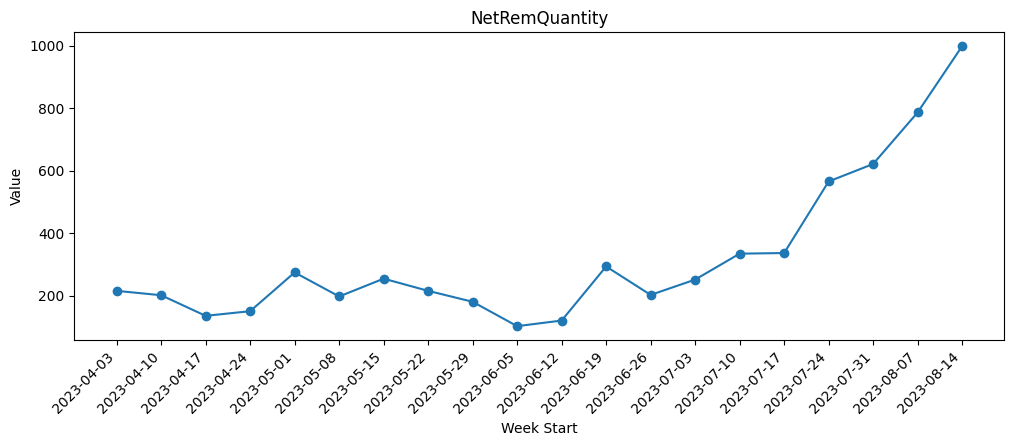

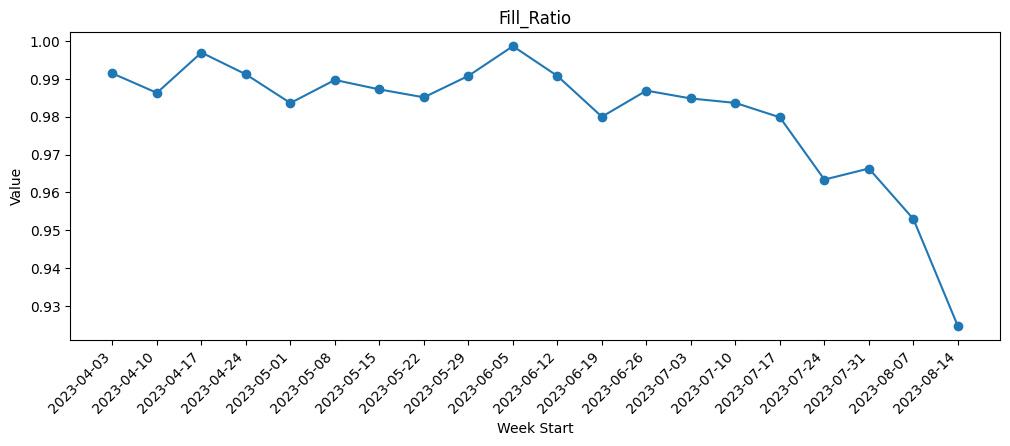

In [16]:
# vendor_week_data = vendor_week_data.tail(20)
vendor_week_data = vendor_week_data.iloc[-25:-5]

# Create individual plots for each variable
plt.figure(figsize=(12, 4))

# Plot VendorCount
plt.plot(vendor_week_data['week_start'], vendor_week_data['VendorCount'], marker='o')
plt.title('VendorCount')
plt.xlabel('Week Start')
plt.ylabel('Value')
plt.xticks(vendor_week_data['week_start'], rotation=45, ha='right')

# Show the VendorCount plot
plt.show()

# Create a new plot for NetQuantity
plt.figure(figsize=(12, 4))
plt.plot(vendor_week_data['week_start'], vendor_week_data['NetQuantity'], marker='o')
plt.title('NetQuantity')
plt.xlabel('Week Start')
plt.ylabel('Value')
plt.xticks(vendor_week_data['week_start'], rotation=45, ha='right')

# Show the NetQuantity plot
plt.show()

# Create a new plot for NetRemQuantity
plt.figure(figsize=(12, 4))
plt.plot(vendor_week_data['week_start'], vendor_week_data['NetRemQuantity'], marker='o')
plt.title('NetRemQuantity')
plt.xlabel('Week Start')
plt.ylabel('Value')
plt.xticks(vendor_week_data['week_start'], rotation=45, ha='right')

# Show the NetRemQuantity plot
plt.show()

# Create a new plot for Fill_Ratio
plt.figure(figsize=(12, 4))
plt.plot(vendor_week_data['week_start'], vendor_week_data['Fill_Ratio'], marker='o')
plt.title('Fill_Ratio')
plt.xlabel('Week Start')
plt.ylabel('Value')
plt.xticks(vendor_week_data['week_start'], rotation=45, ha='right')

# Show the Fill_Ratio plot
plt.show()

In [17]:
# vendor_week_data_quartile=vendor_week_data.sort_values('Fill_Ratio', ascending=False)
# vendor_week_data_quartile['Mix']=vendor_week_data_quartile['Fill_Ratio']*100/vendor_week_data_quartile['Fill_Ratio'].sum()
# vendor_week_data_quartile['CumuSum']=vendor_week_data_quartile['Mix'].cumsum()
# vendor_week_data_quartile['Fill_RatioTag']=0
# vendor_week_data_quartile.loc[vendor_week_data_quartile['CumuSum']<=25,"Fill_RatioTag"]='TopVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>25) & (vendor_week_data_quartile['CumuSum']<=50),"Fill_RatioTag"]='FastMovingVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>50) & (vendor_week_data_quartile['CumuSum']<=75),"Fill_RatioTag"]='SlowMovingVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>75) & (vendor_week_data_quartile['CumuSum']<=101),"Fill_RatioTag"]='NonMovingVendors'

# vendor_week_data_quartile=vendor_week_data_quartile.sort_values('NetQuantity', ascending=False)
# vendor_week_data_quartile['Mix']=vendor_week_data_quartile['NetQuantity']*100/vendor_week_data_quartile['NetQuantity'].sum()
# vendor_week_data_quartile['CumuSum']=vendor_week_data_quartile['Mix'].cumsum()
# vendor_week_data_quartile['NetQuantityTag']=0
# vendor_week_data_quartile.loc[vendor_week_data_quartile['CumuSum']<=25,"NetQuantityTag"]='TopVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>25) & (vendor_week_data_quartile['CumuSum']<=50),"NetQuantityTag"]='FastMovingVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>50) & (vendor_week_data_quartile['CumuSum']<=75),"NetQuantityTag"]='SlowMovingVendors'
# vendor_week_data_quartile.loc[(vendor_week_data_quartile['CumuSum']>75) & (vendor_week_data_quartile['CumuSum']<=101),"NetQuantityTag"]='NonMovingVendors'

# vendor_week_data_quartile = vendor_week_data_quartile[["vendor_id", "NetQuantity", "NetRemQuantity", "Fill_Ratio", "Fill_RatioTag", "NetQuantityTag"]]
# vendor_week_data_quartile